![nsdf](https://www.sci.utah.edu/~pascucci/public/NSDF-large.png)  
[National Science Data Fabric](https://nationalsciencedatafabric.org/) 

# Converting HDF5 data 

- `1420*1420 *310*float32` Each timestep is **2 GiB**
- 900 timesteps **2TB**

In [ ]:
import os ,sys, time, logging,shutil
from datetime import datetime
import numpy as np

import h5py
f = h5py.File('datasets/ff/ff/ff1_000051.h5 ', 'r')

print(f.tree)

#data = a.entry.data.counts.nxdata
#D,H,W=data.shape
##m,M=np.min(data),np.max(data)
#print(f"Nexus load done in {time.time()-t1} seconds \ndtype={data.dtype} \nshape={data.shape} c_size={W*H*D*4:,} \nm={m} M={M}")

# Show slice

In [ ]:
import matplotlib.pyplot as plt
from scipy import ndimage

def ShowData(slice,cmap="viridis"):
	
	# I added this to 'see' the data better, do not know if it makes any scientific sense
	t1=time.time()
	slice=ndimage.percentile_filter(slice, percentile=20, size=16)
	print(f"Filter took {time.time()-t1} seconds to compute")

	print("ShowData",slice.dtype,slice.shape,np.min(slice),np.max(slice))
	plt.imshow(slice, cmap=cmap)
	plt.colorbar()
	plt.show()

X=100
slice=data[:,:,X]
print("data ready")
ShowData(slice)

# Import OpenVisus

In [ ]:
# import 
# sys.path.append(r"C:\projects\OpenVisus\build\RelWithDebInfo")
import OpenVisus as ov

os.environ["VISUS_DISABLE_WRITE_LOCK"]="1"
logger= logging.getLogger("OpenVisus")
# ov.SetupLogger(logger, output_stdout=True) # for debugging
print("OpenVisus imported")

# Create OpenVisus file

In [ ]:
idx_filename="/mnt/data1/nsdf/tmp/3scans_HKLI/visus.idx"

# ************ dangerous (make sure you are in a tmp directory) ************ 
import os,sys,shutil
shutil.rmtree(os.path.dirname(idx_filename), ignore_errors=True)

fields=[ov.Field("data",str(data.dtype),"row_major")]

# NOTE: we are first creating the dataset with no-compression
db=ov.CreateIdx(
	url=idx_filename,
	dims=[W,H,D],
	fields=fields,
	compression="raw")

print(db.getDatasetBody().toString())
print("Dataset created")

# Write  data to OpenVisus

In [ ]:
t1 = time.time()
db.write(data)
print(f"db.write done in {time.time() - t1} seconds")

# Compress using zip

In [ ]:
t1 = time.time()
db.compressDataset(["zip"])
print(f"db.compressDataset done in {time.time()-t1} seconds")

# Show OpenVisus data

In [ ]:
import os,sys
slice=db.read(x=[X,X+1],y=[0,H],z=[0,D], num_refinements=1, quality=0)[:,:,0]
print("data ready")
ShowData(slice)

# Show coarse to fine

In [ ]:
import os,sys
for slice in db.read(x=[X,X+1],y=[0,H],z=[0,D], num_refinements=3, quality=0):
	print("data ready")
	ShowData(slice[:,:,0])

# Get from OpenVisus server

You need to 

- add the dataset to the `/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config`
- launch the Open Visus server


if you want to enable dynmamic dataset  you can do for example:

```
<visus> 

<Configuration> 
    <ModVisus> 
      <Dynamic enabled="true"  filename="/nfs/chess/nsdf01/openvisus/lib64/python3.6/site-packages/OpenVisus/visus.config" msec="10000" /> 
    </ModVisus>
</Configuration>

<datasets>
    <dataset 
       name='recon_combined_1_fullres-arco-1mb' 
       url='/mnt/data1/nsdf/visus-datasets/chess/recon_combined_1_fullres/arco/1mb/zip/visus.idx'  />
</datasets>

</visus>
```

In [ ]:
# Get credentials to access the OpenVisus server
username,password=None,None
with open("/nfs/chess/nsdf01/openvisus/.mod_visus.identity.sh","rt") as file:
    for line in file.read().split():
        if "MODVISUS_USERNAME=" in line:
            username=line[line.index("MODVISUS_USERNAME=")+len("MODVISUS_USERNAME="):].strip()
            continue
        if "MODVISUS_PASSWORD=" in line:
            password=line[line.index("MODVISUS_PASSWORD=")+len("MODVISUS_PASSWORD="):].strip()
            continue

db=ov.LoadDataset(f"https://nsdf01.classe.cornell.edu/mod_visus?dataset=3scans_HKLI&~auth_username={username}&~auth_password={password}")
slice=db.read(x=[X,X+1],y=[0,H],z=[0,D], num_refinements=1, quality=0)[:,:,0]
print("data ready")
ShowData(slice)

# New HDF5 data (Far Field)

In [1]:
from nexusformat.nexus import * 

from nexusformat.nexus.tree import NX_CONFIG
NX_CONFIG['memory']=4000

a=nxload("/nfs/chess/daq/current/id3a/nygren-3738-a/ss718-1ff/5/ff/ff1_000051.h5")
print(a.tree)

root:NXroot
  imageseries:NXimageseries
    images = uint16(1445x3888x3072)
      @NDArrayDimBinning = [1 1]
      @NDArrayDimOffset = [0 0]
      @NDArrayDimReverse = [0 0]
      @NDArrayNumDims = 2
      @signal = 1
    instrument:NXinstrument
      NDAttributes:NXcollection
        @hostname = 'mc67du'
        NDArrayEpicsTSSec = uint32(1445)
          @NDAttrDescription = 'The NDArray EPICS timestamp seconds past epoch'
          @NDAttrName = 'NDArrayEpicsTSSec'
          @NDAttrSource = 'Driver'
          @NDAttrSourceType = 'NDAttrSourceDriver'
        NDArrayEpicsTSnSec = uint32(1445)
          @NDAttrDescription = 'The NDArray EPICS timestamp nanoseconds'
          @NDAttrName = 'NDArrayEpicsTSnSec'
          @NDAttrSource = 'Driver'
          @NDAttrSourceType = 'NDAttrSourceDriver'
        NDArrayTimeStamp = float64(1445)
          @NDAttrDescription = 'The timestamp of the NDArray as float64'
          @NDAttrName = 'NDArrayTimeStamp'
          @NDAttrSource = 'Driver'
    

data ready
Filter took 33.09303522109985 seconds to compute


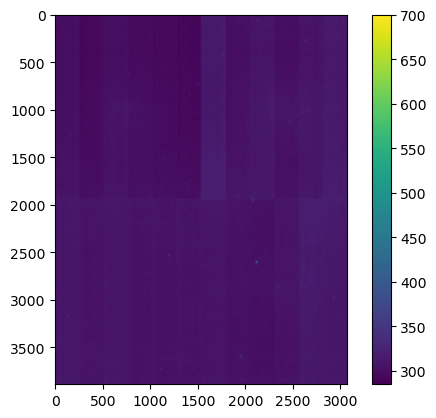

In [20]:
import matplotlib.pyplot as plt
from scipy import ndimage
import time
import numpy as np

def ShowData(slice,cmap="viridis"):
	
	if True:
		t1=time.time()
		slice=ndimage.percentile_filter(slice, percentile=20, size=16)
		print(f"Filter took {time.time()-t1} seconds to compute")

	plt.imshow(slice, cmap=cmap)
	plt.colorbar()
	plt.show()

slice=a.imageseries.images[100,:,:]
print("data ready")
ShowData(slice)